# Smoothed Autocorrelation Function for Rotation Periods

Roughly following the prescription in McQuillan et al. (2013), but approximating the uncertainty in rotation period differently.


### Method

To measure rotation period: 

* normalize and median subtract fluxes of each quarter
* interpolate over missing data
* measure autocorrelation function
* smooth autocorrelation function with gaussian convolution as in McQuillan et al. (2013)
* measure period at primary peak of smoothed ACF
* take the median quarterly period is the true period, use standard deviation of quarterly periods as uncertainty

### Kepler-17

In [5]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from glob import glob
import os

# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')
from starspots.lightcurve import LightCurve, concatenate_light_curves
from starspots.systemparams import k17_params_morris
from scipy.ndimage import gaussian_filter
import numpy as np

import interpacf
import matplotlib.pyplot as plt

light_curve_paths = glob('/local/tmp/kepler17/*slc.fits')

depth = 0.00343
k17_params = k17_params_morris()

# Construct light curve object from the raw data
whole_lc = LightCurve.from_raw_fits(light_curve_paths, name='K17',
                                    transit_params=k17_params)
whole_lc = LightCurve(name='k17',
                      **whole_lc.mask_in_transit(oot_duration_fraction=0.5))

# Compute maxes for each quarter
available_quarters = whole_lc.get_available_quarters()
quarters = [whole_lc.get_quarter(q) for q in whole_lc.get_available_quarters()]

for quarter in quarters:
    quarter.errors /= np.median(quarter.fluxes)
    quarter.fluxes /= np.median(quarter.fluxes)
    
normalized_lc = concatenate_light_curves(quarters)

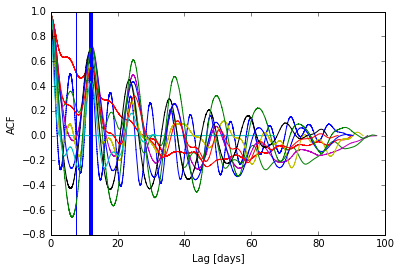

In [6]:

k17periods = []
for quarter in quarters:
    if quarter.quarters[0] != 0:
        lag, acf = interpacf.interpolated_acf(quarter.times.jd, 
                                              quarter.fluxes - np.median(quarter.fluxes))
        detected_period = interpacf.dominant_period(lag, acf, min=5, max=15)

        plt.plot(lag, acf/np.max(acf))
        plt.axvline(detected_period)
        k17periods.append(detected_period)
        plt.xlabel('Lag [days]')
        plt.ylabel('ACF')

In [8]:
print("Kepler-17 rotation period = {0} +/- {1}"
      .format(np.nanmedian(k17periods), 
              np.nanstd(k17periods)/len([period for period in k17periods 
                                         if not np.isnan(period)])))

Kepler-17 rotation period = 12.043456287123263 +/- 0.11989143790585778
